# Causal Inference - Double Machine Learning

## Install Requirements

In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dowhy
from prophet import Prophet
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from econml.dml import LinearDML

from IPython.display import Image, display

import warnings

## Generate simulated data

In [148]:
# Set random seed for reproducibility
np.random.seed(42)

# Create a time series index
date_range = pd.date_range(start='2020-01-01', end='2023-12-31', freq='W-MON')

# Generate data
df = pd.DataFrame({'week': date_range})

# Create trend with growth
df['trend'] = np.linspace(100, 300, len(date_range))

# Add seasonal component with oscillation around 0
df['seasonality'] = 50 * np.sin(2 * np.pi * df.week.dt.isocalendar().week / 52)

df['baseline_sales'] =  df['trend'] + df['seasonality'] 

# # Add advertising spend correlated to sales

df['media_incremental_sales'] = 0.3 * df['baseline_sales'] 
df['adspend'] = df['media_incremental_sales'] /2

# Calculate total sales
df['sales'] = df['baseline_sales']  + 2 * df['adspend'] + np.random.normal(loc=0, scale=15, size=len(date_range))

display(df.head())

,week,trend,seasonality,baseline_sales,media_incremental_sales,adspend,sales
0,2020-01-06,100.000000,11.965783,111.965783,33.589735,16.794867,153.00623
1,2020-01-13,100.966184,17.730244,118.696428,35.608928,17.804464,152.231392
2,2020-01-20,101.932367,23.236159,125.168526,37.550558,18.775279,172.434412
3,2020-01-27,102.898551,28.403237,131.301788,39.390536,19.695268,193.537772
4,2020-02-03,103.864734,33.156133,137.020867,41.10626,20.55313,174.614827


In [150]:
## Visualize Generated data

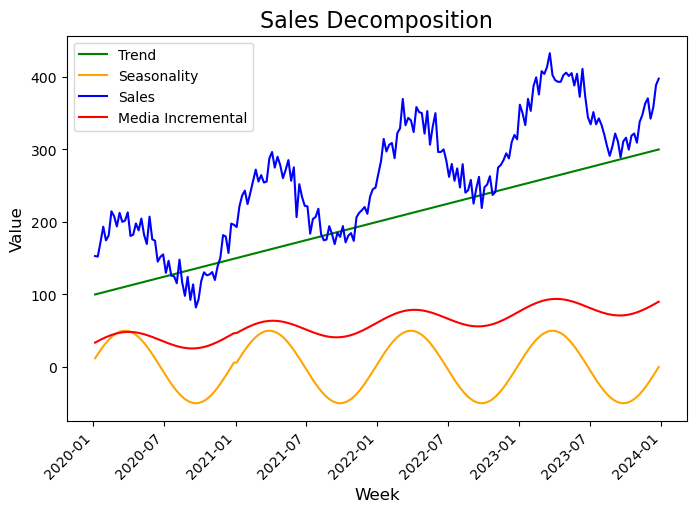

In [152]:


plt.figure(figsize=(8, 5))

sns.lineplot(x=df['week'], y=df['trend'], label="Trend", color="green")
sns.lineplot(x=df['week'], y=df['seasonality'], label="Seasonality", color="orange")
sns.lineplot(x=df['week'], y=df['sales'], label="Sales", color="blue")
sns.lineplot(x=df['week'], y=df['media_incremental_sales'], label="Media Incremental", color="red")

plt.title('Sales Decomposition', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

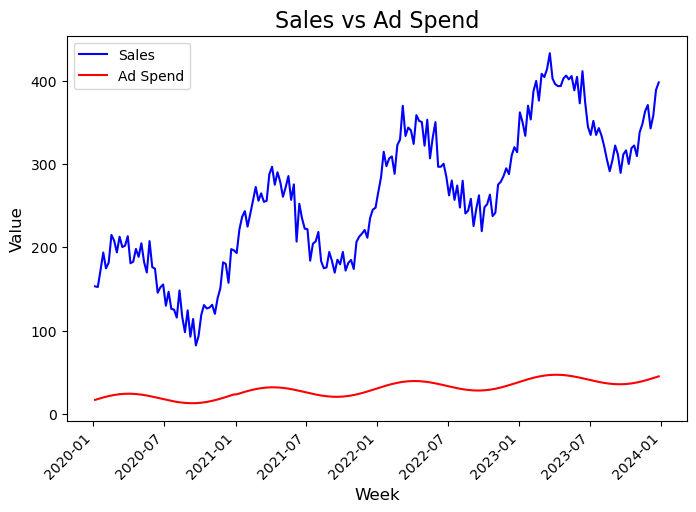

In [154]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['week'], y=df['sales'], label="Sales", color="blue")
sns.lineplot(x=df['week'], y=df['adspend'], label="Ad Spend", color="red")

plt.title('Sales vs Ad Spend', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

In [156]:
adspend_perc_sales = df["adspend"].sum() / df["sales"].sum() * 100
media_contribution = df["media_incremental_sales"].sum() / df["sales"].sum() * 100
incr_roas = df["media_incremental_sales"].sum() / df["adspend"].sum() 

print(f'Adspend as a percentage of sales = {adspend_perc_sales:.4f}%')
print(f'Media contribution as a percentage of sales = {media_contribution:.4f}%')
print(f'Incremental ROAS = {incr_roas:.2f}')

Adspend as a percentage of sales = 11.5589%
Media contribution as a percentage of sales = 23.1179%
Incremental ROAS = 2.00


In [158]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        208 non-null    datetime64[ns]
 1   y         208 non-null    Float64       
 2   adspend   208 non-null    Float64       
 3   trend     208 non-null    float64       
 4   season_y  208 non-null    float64       
dtypes: Float64(2), datetime64[ns](1), float64(2)
memory usage: 8.7 KB


## Draw the Causal Diagram

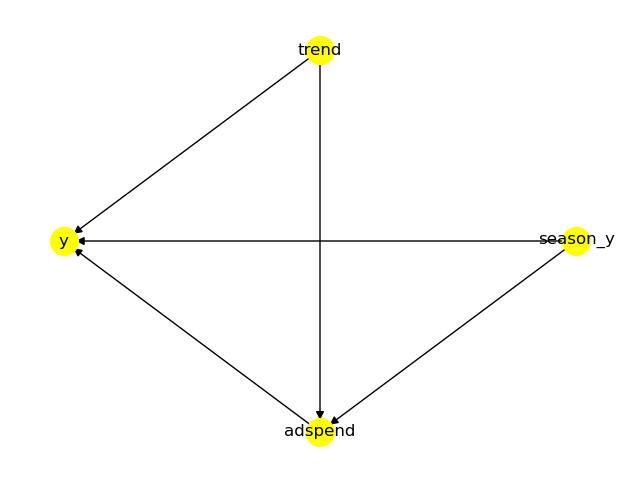

In [161]:
causal_graph = """digraph {
y;
adspend;
season_y;
trend;
trend -> y;
trend -> adspend;
season_y -> y;
season_y -> adspend;
adspend -> y;
}"""

estimand = dowhy.CausalModel(data=df_model,
                     graph=causal_graph.replace("\n", " "),
                     treatment="adspend",
                     outcome="y")
estimand.view_model()


## Use Prophet to decompose sales and get trend and seasonality

16:15:31 - cmdstanpy - INFO - Chain [1] start processing
16:15:31 - cmdstanpy - INFO - Chain [1] done processing


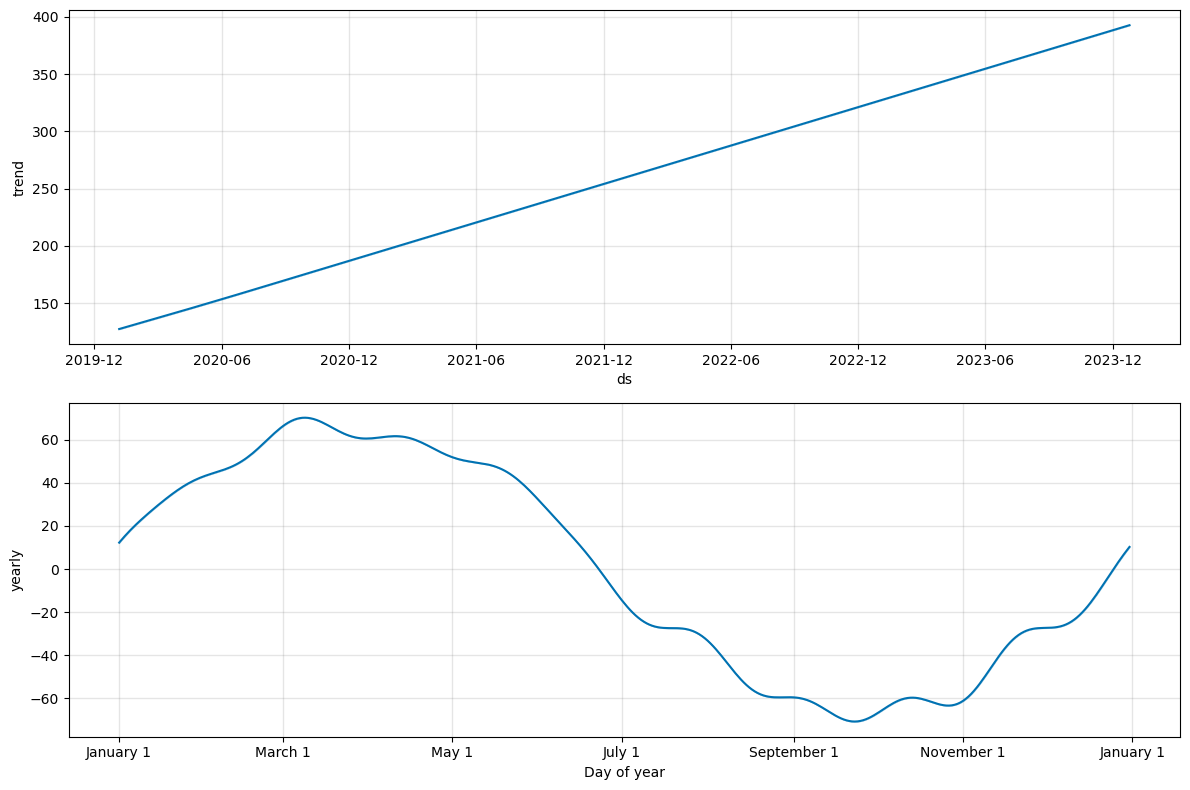

In [164]:
df_model = pd.DataFrame()
df_model['ds'] = df['week']
df_model['y'] = df['sales']
df_model['adspend'] = df['adspend']

prophet = Prophet(yearly_seasonality=True)
prophet.fit(df_model)
prophet_predict = prophet.predict(df_model)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plot = prophet.plot_components(prophet_predict, figsize = (12, 8))

prophet_columns = [col for col in prophet_predict.columns if not col.endswith(("upper", "lower"))]

df_model["trend"] = prophet_predict["trend"]
df_model["season_y"] = prophet_predict["yearly"]


# df_model["trend"] = df["trend"]
# df_model["season_y"] = df["seasonality"]


## Check correlations

<Axes: >

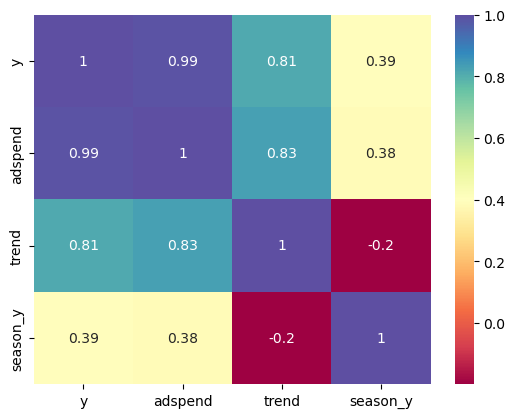

In [167]:
sns.heatmap(df_model.select_dtypes(include = np.number).corr(), annot=True, cmap = 'Spectral')

## Recover impact of adspend using Linear Regression

In [170]:
# Set target and features
y = df_model['y']
X = df_model[['trend', 'season_y', 'adspend']]

# Train model 
model = LinearRegression()
model = model.fit(X, y)

# Extract the treatment coefficient
ate_lr = np.round(model.coef_[2], 4)

print(f'The average treatment effect using Linear Regression is: {ate_lr}')

The average treatment effect using Linear Regression is: 1.9089


## Recover impact of adspend using Frisch-Waugh-Lovell theorem

In [173]:
# Set treatment, outcome and confounder samples
treatment = df_model['adspend'].to_numpy().reshape(-1,1)
outcome = df_model['y'].to_numpy().reshape(-1,1)
confounder = df_model[['season_y', 'trend']].to_numpy().reshape(-1,2)

# Train treatment model and calculate residuals
treatment_model = LinearRegression()
treatment_model = treatment_model.fit(confounder, treatment)
treatment_pred = treatment_model.predict(confounder)
treatment_residuals = treatment - treatment_pred

# Train outcome model and calculate residuals
outcome_model = LinearRegression()
outcome_model = outcome_model.fit(confounder, outcome)
outcome_pred = outcome_model.predict(confounder)
outcome_residuals = outcome - outcome_pred

# Train residual model and calculate average treatment effect
final_model = LinearRegression()
final_model = final_model.fit(treatment_residuals, outcome_residuals)
ate_fwl = np.round(final_model.coef_[0][0], 4)

print(f'The average treatment effect is: {ate_fwl}')

The average treatment effect is: 1.9089


## Recover impact of adspend using DoWhy and EconML

In [176]:
identified_estimand = estimand.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                          
──────────(E[y|trend,season_y])
d[adspend]                     
Estimand assumption 1, Unconfoundedness: If U→{adspend} and U→y then P(y|adspend,trend,season_y,U) = P(y|adspend,trend,season_y)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [277]:
estimate = estimand.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
     method_params={
        'init_params': {
            'discrete_treatment': False,
            'random_state' : 50
        },
        'fit_params': {},
         'y' : df_model['y'].to_numpy().flatten(),
         'T' :df_model['adspend'].to_numpy().flatten(),
         'X' : None,
         'W' : df_model[['season_y', 'trend']].to_numpy().reshape(-1,2)
    }
)
print(estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                          
──────────(E[y|trend,season_y])
d[adspend]                     
Estimand assumption 1, Unconfoundedness: If U→{adspend} and U→y then P(y|adspend,trend,season_y,U) = P(y|adspend,trend,season_y)

## Realized estimand
b: y~adspend+trend+season_y | 
Target units: ate

## Estimate
Mean value: 1.9709115773804837
Effect estimates: [1.97091158 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158
 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158
 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158
 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158
 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158
 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158
 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158 1.97091158
 1.97091158 1.97091158 1.9709

In [279]:
refutation = estimand.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=20)
print(refutation)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Refute: Use a Placebo Treatment
Estimated effect:1.9709115773804837
New effect:-0.011225583406319881
p value:0.45167216154431045



## Final Comparison

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


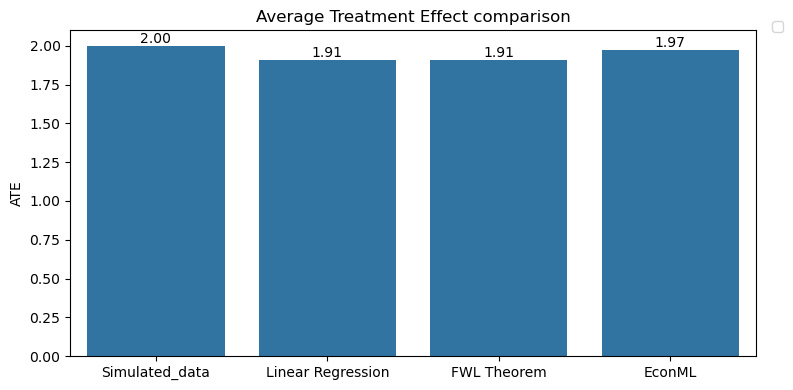

In [283]:
# Plot comparison of results

categories = ['Simulated_data','Linear Regression', 'FWL Theorem', 'EconML']
plt.figure(figsize = (8,4))
ax = sns.barplot(x=categories, y=[incr_roas, ate_lr, ate_fwl, 1.97091158])

for p in ax.patches:
    label = "{:.2f}".format(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(label, (x, y), ha="center", va="center", 
                size=10, xytext=(0, 5), textcoords="offset points",) 
    
plt.ylabel('ATE')
plt.title('Average Treatment Effect comparison')
plt.legend(bbox_to_anchor = (1.05, 1.05))
plt.tight_layout()
plt.show()